In [1]:
import torch

from e2cnn import gspaces
from e2cnn import nn
from matplotlib import pyplot as plt

In [2]:
r2_act = gspaces.Rot2dOnR2(N=4)
feat_type_in = nn.FieldType(r2_act, 3*[r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 8*[r2_act.regular_repr])
feat_type_out = nn.FieldType(r2_act, 1*[r2_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
    # nn.PointwiseAvgPool(feat_type_out,kernel_size=4),
).eval()

/home/wagner/Development/deeplearning/singular-points/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [3]:
from e2cnn import nn
import numpy as np
class CircleMask(torch.nn.Module):
    def __init__(self,feat_type_in,h, w, center=None, radius=None):
        super().__init__()
        self.feat_type =feat_type_in
        if center is None:  # use the middle of the image
            center = (int(w / 2), int(h / 2))
        if radius is None:  # use the smallest distance between the center and image walls
            radius = min(center[0], center[1], w - center[0], h - center[1])
        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
        self.mask = dist_from_center <= radius
        self.mask = torch.tensor(self.mask)
        

    def forward(self, x):
        x = x*self.mask[None]
        print(x.min(),x.max())
        x = nn.GeometricTensor(x[None], self.feat_type)
        return x

In [6]:
def describe_feature(ativate_map,point_0,point_1):
    filtro = ativate_map[0,:,point_0[0]:point_1[0],point_0[1]:point_1[1]]
    print(filtro.shape)
    g_size,h,w = filtro.shape[1:]
    mask1 = CircleMask(feat_type_out,h,w)
    f = mask1(filtro.tensor[0])
    print(f.shape,type(f))
    for i in range(g_size):
        plt.imshow(f.tensor[0][i].cpu().detach(), vmin=-2, vmax=2)
        plt.show()
    pool = nn.PointwiseAvgPool(feat_type_out,kernel_size=5)
    f_pool = pool(f)
    return f_pool
# describe_feature(y,(25,100),(40,115))

torch.Size([2, 3, 140, 140])
torch.Size([2, 3, 140, 140])
torch.Size([1, 4, 21, 21])
tensor(-1.3430, grad_fn=<MinBackward1>) tensor(1.4977, grad_fn=<MaxBackward1>)
torch.Size([1, 4, 21, 21]) <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>


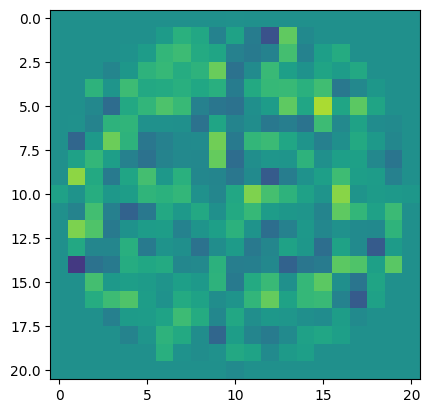

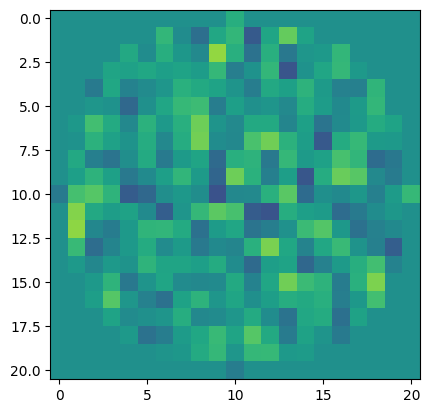

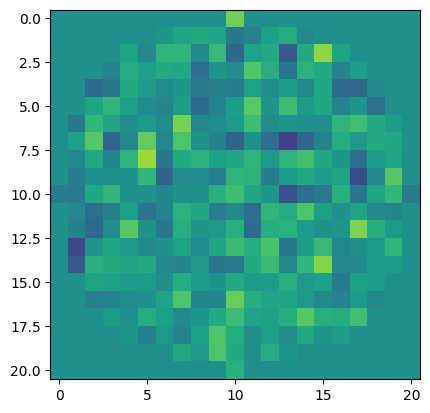

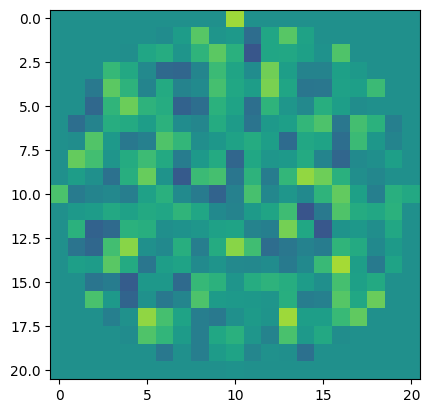

<class 'e2cnn.nn.geometric_tensor.GeometricTensor'> torch.Size([2, 4, 134, 134])
torch.Size([1, 4, 21, 21])
tensor(-1.3430) tensor(1.4977)
torch.Size([1, 4, 21, 21]) <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>


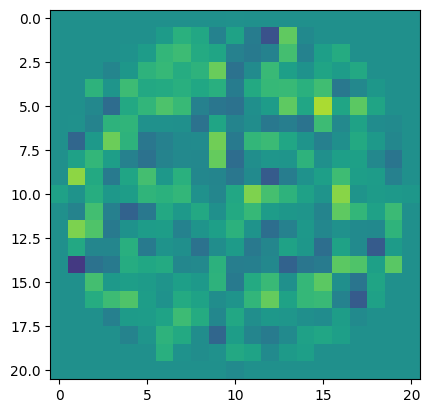

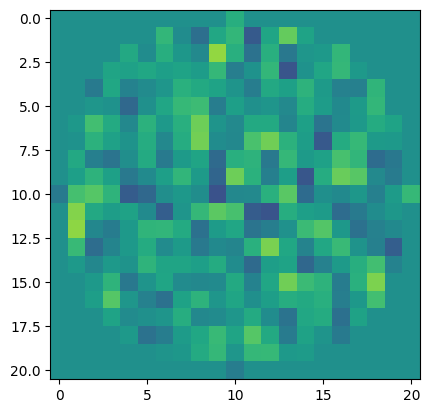

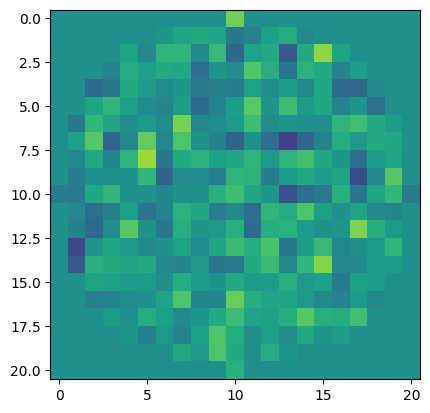

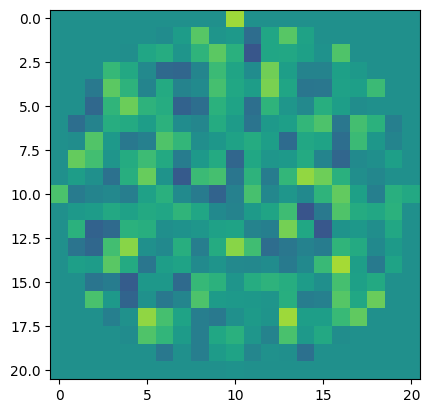

torch.Size([1, 4, 21, 21])
tensor(-1.3430) tensor(1.4007)
torch.Size([1, 4, 21, 21]) <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>


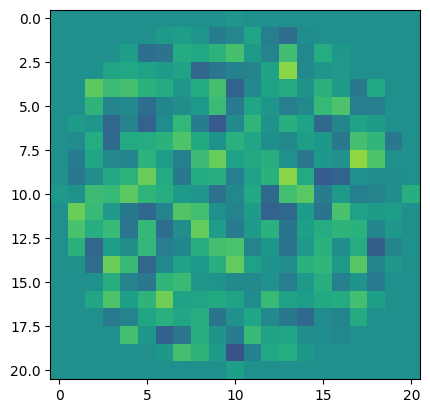

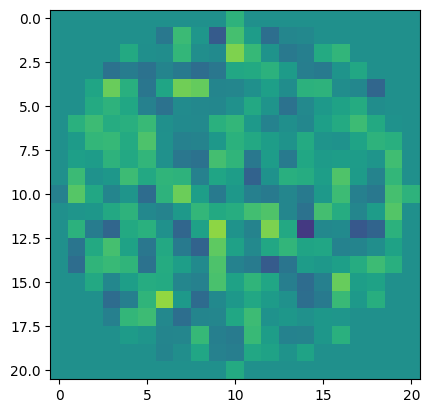

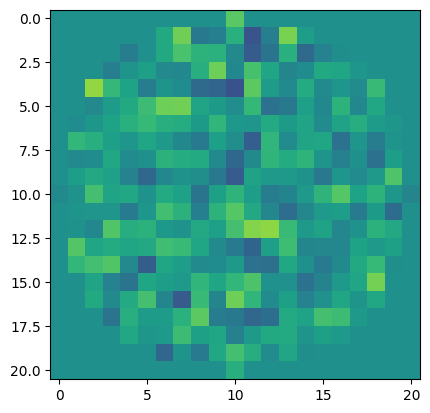

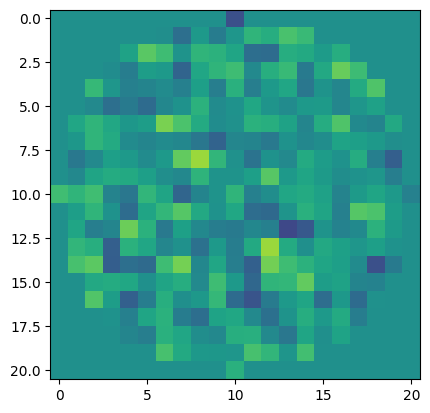

torch.Size([1, 4, 21, 21])
tensor(-0.9984) tensor(1.4187)
torch.Size([1, 4, 21, 21]) <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>


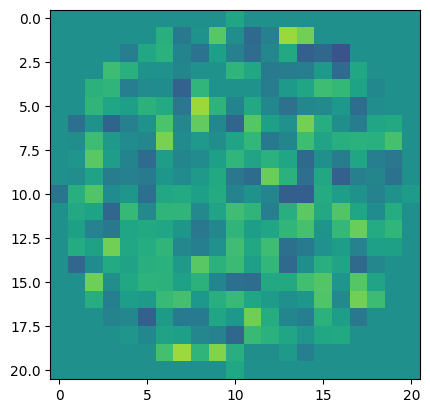

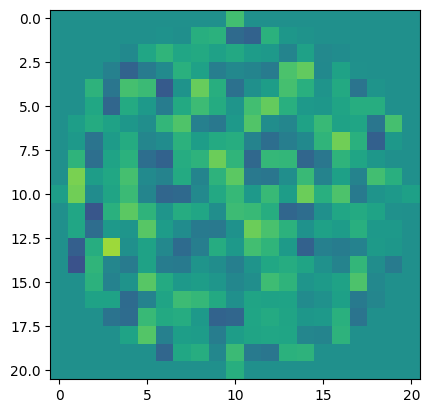

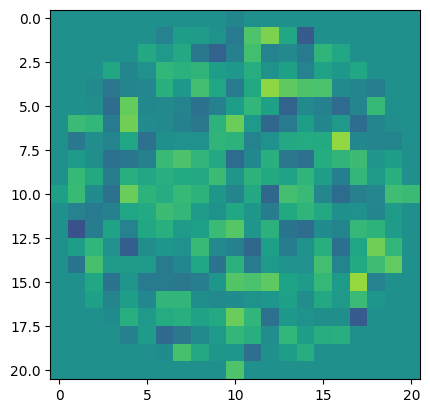

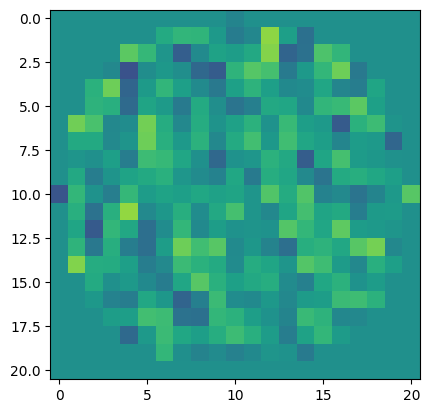

torch.Size([1, 4, 21, 21])
tensor(-1.3947) tensor(1.4977)
torch.Size([1, 4, 21, 21]) <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>


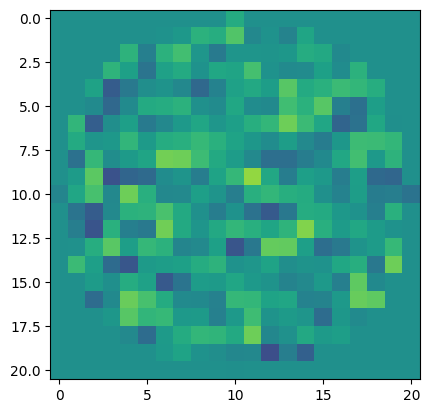

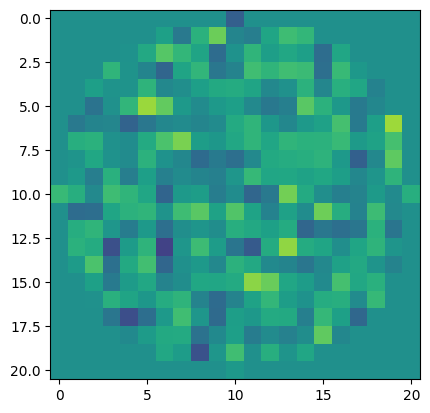

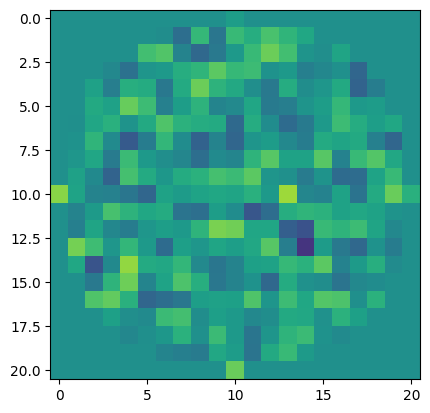

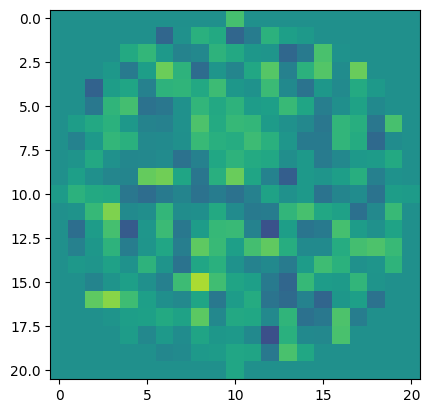

In [7]:
x = torch.randn(2, 3, 140, 140)
print(x.shape)
x = nn.GeometricTensor(x, feat_type_in)
print(x.shape)
y = model(x)
desc_1 = describe_feature(y,(60,60),(81,81))
print(type(y),y.shape)
# for each group element
for g in r2_act.testing_elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = model(x_transformed)
    
    y_transformed_from_x = y.transform(g)
    
    desc_2 = describe_feature(y_transformed_from_x,(60,60),(81,81))
    # print(y_transformed_from_x.shape,y_transformed_from_x.tensor[0, ...].detach().numpy().squeeze(),'\n')
    # print(desc_1.tensor[0, ...].detach().numpy().squeeze(),desc_2.tensor[0, ...].detach().numpy().squeeze(),'\n')
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g
    # assert torch.allclose(desc_1.tensor, desc_2.tensor, atol=1e-5), g

In [1]:
import json

x = {
  "name": "Ken",
  "age": 45,
  "married": True,
  "children": ("Alice","Bob"),
  "pets": ['Dog'],
  "cars": [
    {"model": "Audi A1", "mpg": 15.1},
    {"model": "Zeep Compass", "mpg": 18.1}
  ]
}
# sorting result in asscending order by keys:
sorted_string = json.dumps(x, indent=4, sort_keys=True)
print(sorted_string)

{
    "age": 45,
    "cars": [
        {
            "model": "Audi A1",
            "mpg": 15.1
        },
        {
            "model": "Zeep Compass",
            "mpg": 18.1
        }
    ],
    "children": [
        "Alice",
        "Bob"
    ],
    "married": true,
    "name": "Ken",
    "pets": [
        "Dog"
    ]
}


In [14]:
result ={}
result['image'] = 'base64'

detects = list()
detects.append({'box':[[1,2],[2,1]],'img':'base64'})
detects.append({'box':[[2,2],[2,2]],'img':'base64'})

result['detects'] = list(detects)
result

{'image': 'base64',
 'detects': [{'box': [[1, 2], [2, 1]], 'img': 'base64'},
  {'box': [[2, 2], [2, 2]], 'img': 'base64'}]}

In [ ]:
def write_detects(img,result):
    result ={}
    result['image'] = 'base64'
    

In [35]:
div = 20//2
div

10

In [31]:
(div,div+1) if 21%2!=0 else (div,div)

(10, 11)

In [36]:
import math
20-div

10